## Task 1 – On the use of distance information for UwaveGesture Recognition Task
Homework 2 introduced the description of the gesture recognition task with the accelerometer data.
This task will involve evaluation of alternative strategies using both training and test data provided on
https://drive.google.com/drive/u/1/folders/13553neknux7U8why55KM1WrjgkA9IJKm (same link as in
Homework 2).
Use the UWave data provided in the second homework for this task. In the second homework, you were
given only the training data. This task requires performing classification task on the test data and
evaluate the performance of certain classifiers. Test data is uploaded as *.zip files for each axis (i.e. X,
Y and Z). It has the same format as the training data.

In [1]:
from time import time
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
plt.style.use("ggplot")

def read_data(path):
    with open(path, "r") as file:
        lines = file.readlines()
    
    classes = [float(x.replace("  ", " ").split()[0]) for x in lines]
    lines = [list(map(float, x.replace("  ", " ").split()))[1:] for x in lines]
    return np.array(lines), classes

In [2]:
X_train_acc, X_train_classes = read_data("../HW2/uWaveGestureLibrary_X_TRAIN")
Y_train_acc, Y_train_classes = read_data("../HW2/uWaveGestureLibrary_Y_TRAIN")
Z_train_acc, Z_train_classes = read_data("../HW2/uWaveGestureLibrary_Z_TRAIN")

print(X_train_acc.shape, Y_train_acc.shape, Z_train_acc.shape)
assert X_train_classes == Y_train_classes  
assert X_train_classes == Z_train_classes

train_classes = X_train_classes
train_classes = np.array(train_classes)
del X_train_classes, Y_train_classes, Z_train_classes

(896, 315) (896, 315) (896, 315)


In [3]:
X_test_acc, X_test_classes = read_data("./uWaveGestureLibrary_X_TEST")
Y_test_acc, Y_test_classes = read_data("./uWaveGestureLibrary_Y_TEST")
Z_test_acc, Z_test_classes = read_data("./uWaveGestureLibrary_Z_TEST")

print(X_test_acc.shape, Y_test_acc.shape, Z_test_acc.shape)
assert X_test_classes == Y_test_classes  
assert X_test_classes == Z_test_classes

test_classes = X_test_classes
test_classes = np.array(test_classes)
del X_test_classes, Y_test_classes, Z_test_classes

(3582, 315) (3582, 315) (3582, 315)


In [4]:
train_data = np.concatenate([X_train_acc, Y_train_acc, Z_train_acc], axis=1)
test_data = np.concatenate([X_test_acc, Y_test_acc, Z_test_acc], axis=1)

## a)
Suppose we decided to apply a nearest-neighbor (NN) classifier to find the labels of test
instances. You can use the strategy you employed when you apply PCA to this data in
Homework 2 (i.e. concatenation of the axes). Propose two distance measures for computing
similarity between two time series. The distance calculation on the concatenated time series
implicitly weights the distances of each axis in an equal way. For each distance measure
1
alternative, use the training data to identify the ideal value of k which minimizes the error of a
10-fold cross-validation.

In [5]:
# Lets check # of observations in each class
np.unique(train_classes, return_counts=True)

(array([1., 2., 3., 4., 5., 6., 7., 8.]),
 array([122, 108, 106, 110, 127, 111, 112, 100]))

Sklearn's KNN function scores performance with mean accuracy which makes sense since no class is more important than the other one in this task and the # of observations from each class are a little imbalanced.

In [6]:
dist_results = {}
for distance in ("euclidean", "manhattan", "chebyshev"):
    accuracies = []
    for k in range(1,20):
        classifier = KNeighborsClassifier(n_neighbors=k, n_jobs=1, metric=distance)
        mean_accuracy = cross_val_score(classifier, X=train_data, y=train_classes, cv=10)
        mean_accuracy = np.mean(mean_accuracy)
        accuracies.append(mean_accuracy)
    dist_results[distance] = accuracies
    print(f"{distance}: ", max(accuracies), " K: ", np.argmax(accuracies)+1)

euclidean:  0.9441947565543071  K:  3
manhattan:  0.9587390761548065  K:  1
chebyshev:  0.8526466916354556  K:  1


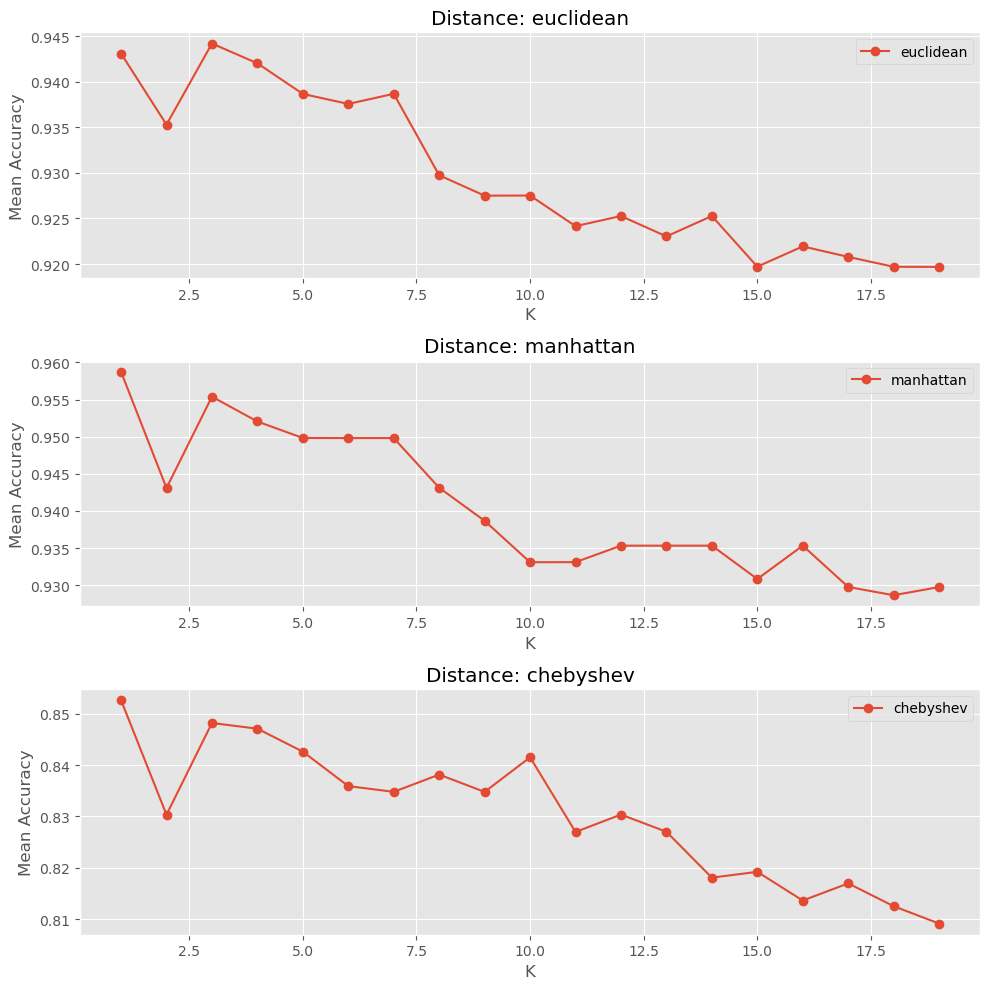

In [7]:
fig = plt.figure(figsize=(10,10))
for i, dist in enumerate(dist_results):
    to_plot = dist_results[dist]
    ax = fig.add_subplot(3, 1, i+1)
    ax.plot(list(range(1,20)), to_plot, label=dist, marker="o")
    ax.set_xlabel("K")
    ax.set_ylabel("Mean Accuracy")
    ax.set_title(f"Distance: {dist}")
    ax.legend()
plt.tight_layout()
plt.show()

The best result is obtained from manhattan dist with K=1 and mean accuracy :0.9587390761548065

## b) 
Using the value of k (identified for each distance measure) in part (a) and evaluate your final
performance on the test data and present your results in a (8-by-8) confusion matrix, showing
the counts for actual and predicted labels. In addition, quote the runtime and accuracy for your
results.

Test Accuracy:  0.954215522054718


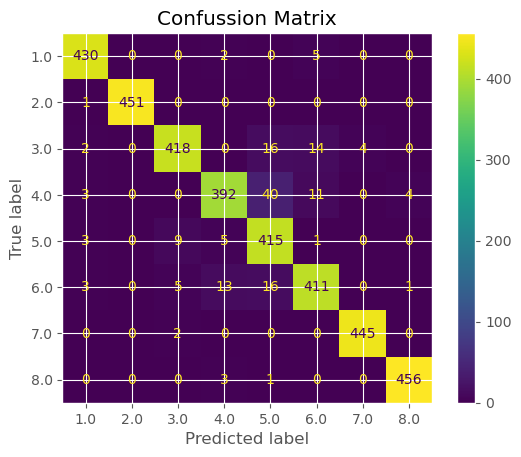

Time Elapsed:  1.7338721752166748


In [8]:
K=1
distance = "manhattan"

start = time()
classifier = KNeighborsClassifier(n_neighbors=K, n_jobs=1, metric=distance)
classifier.fit(train_data, train_classes)

preds = classifier.predict(test_data)

accuracy = sum(preds == test_classes)/len(test_classes)
print("Test Accuracy: ", accuracy)

ConfusionMatrixDisplay.from_predictions(test_classes, preds)
plt.title("Confussion Matrix")
plt.show()

print("Time Elapsed: ", time()-start)

## c)
The observations from different axes are weighted equally if we compute the distance over each
axis and sum them to obtain a final similarity measure. Is this reasonable? For example, we can
compute the distance as below:
final_dist = w1*dist_x + w2*dist_y + w3*dist_z
where DistX is the distance based on the acceleration only on X axis, DistY is for Y axis and so
on. Do you think weighting the distances over different axes to obtain a final similarity measure
makes sense for classification? Why?

Yes it does makes senes because the real gestures are two dimensional and the ones in the data is 3d which means a movement in the one of the axe does not matter as much as the others. Also the other two axes can have different importance in the classification settings. Therefore creating an optimal weighting is expected to perform better in this setting. 

## Task 2 – Linear models on alternative representations of the data
Recall that most of the machine learning problems assume that we have a nice and informative
representation of the data (after data selection, preprocessing and transformation steps). In part (a), we
have preprocessed the information from each axis to obtain our feature vector (of 3T length which
keeps the information about X, Y and Z axis).
Suppose we are willing to perform a binary classification task to identify if a test time series is from
Class 3.

## a)
Train a logistic regression model on the training data and use the model to make a prediction on the
test data. Note that you will obtain probabilistic predictions (i.e. probability of a time series being from
Class 3 if you encoded Class 3 as 1 in binary classification setting). This will require you to select a
threshold since 0.5 as a threshold may not work well under this imbalanced class setting. To make
2
things easier, use the ratio of Class 3 instances in the training data as threshold. Use the learned model
to predict the class for test data. Present your results in a (2-by-2) confusion matrix

TH:  0.12674483528754885
Matthews corr coef: 0.574478460648854, F1: 0.628696604600219, ROC-AUC: 0.9090599896346203


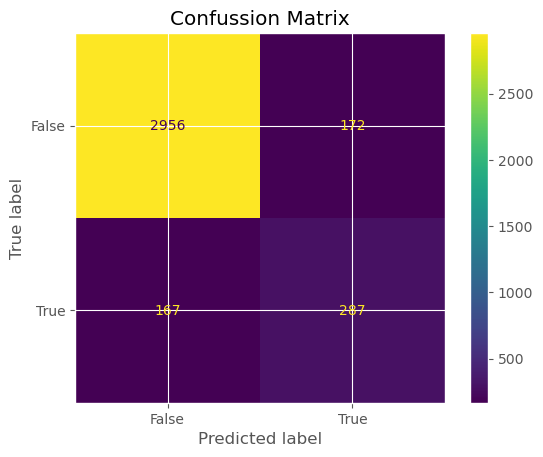

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, f1_score , roc_auc_score
    
new_train_classes = (train_classes==3)
new_test_classes = (test_classes==3)

classifier = LogisticRegression(max_iter=1000, penalty="none")
classifier.fit(train_data, new_train_classes)
pred_probs = classifier.predict_proba(test_data)

th = sum(new_test_classes)/len(new_test_classes)
print("TH: ", th)
preds = (pred_probs < th)[:, 0]

print(f"Matthews corr coef: {matthews_corrcoef(new_test_classes, preds)}, F1: {f1_score(new_test_classes, preds)}, ROC-AUC: {roc_auc_score(new_test_classes, pred_probs[:,1])}" )

ConfusionMatrixDisplay.from_predictions(new_test_classes, preds)
plt.title("Confussion Matrix")
plt.show()

Since we used a naive approach to determine the threshold. it would be better to consider ROC-AUC primarily since it is a metric independent of the threshold value. However it is good to keep an eye on the MCC and F1.

## b) 
An advantage of logistic regression is related to the interpretability however when we have large
number of features together with a method without penalization, it is harder to interpret the results.
Therefore, an alternative way is to train a logistic regression model with lasso penalties. This will
require you setting of penalization term (namely lambda). Use 10-fold cross-validation to determine
your ideal lambda level based on binomial deviance (Note that we have used accuracy as primary
metric to determine the lambda in class, however this strategy may not work well for the imbalanced
data). You can check http://www.inf.ed.ac.uk/teaching/courses/mlsc/Notes/Lecture4/MLSC_Lec4.pdf
for details of binomial deviance. This is also referred to as logistic loss. If you are using “glmnet”
package in R, “type.measure” can be set to “deviance” which is the default value. If you are Python
user, sklearn module has “LogisticRegressionCV” function in which you can provide the scorer as
“metrics.log_loss”.
Once you determine your best lambda value using 10-fold cross-validation, perform classification on
test data similar to part a and compare your results. Comment on the regression coefficients. Is there
any interesting information? Try to interpret the model.

Regularization term:  [2.7825594]
TH:  0.12674483528754885
Neg. Log Loss:  -0.12551851830460875
Matthews corr coef: 0.6392718688054163, F1: 0.6172465960665658, ROC-AUC: 0.9780855312820399


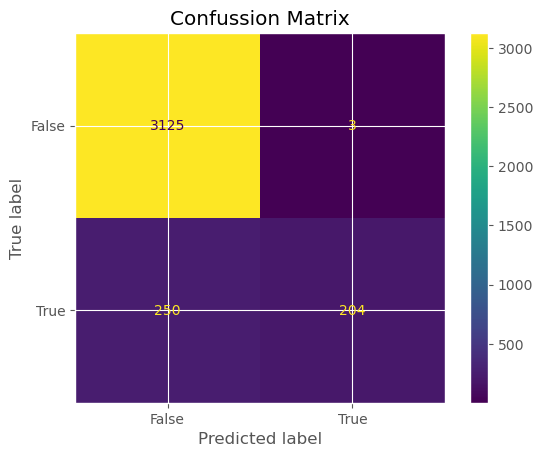

In [10]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss

classifier = LogisticRegressionCV(cv=10, penalty="l1", scoring='neg_log_loss', max_iter=1000, solver="liblinear")
classifier.fit(train_data, new_train_classes)
pred_probs = classifier.predict_proba(test_data)
print("Regularization term: ", 1/classifier.C_)

th = sum(new_test_classes)/len(new_test_classes)
print("TH: ", th)
preds = (pred_probs < th)[:, 0]
log_loss = classifier.score(test_data, new_test_classes)
print("Neg. Log Loss: ", log_loss)
print(f"Matthews corr coef: {matthews_corrcoef(new_test_classes, preds)}, F1: {f1_score(new_test_classes, preds)}, ROC-AUC: {roc_auc_score(new_test_classes, pred_probs[:, 1])}" )


ConfusionMatrixDisplay.from_predictions(new_test_classes, preds)
plt.title("Confussion Matrix")
plt.show()

It seems like the model with lasso penalty obtained better ROC-AUC and MCC but a little less F1. Considering two metrics improved significantly this could be considered as a better model, especially a better threshold selection method is considered. However with this threshold one could prefer the non-regularized model depending on the problem definition since both model has different rates in True Positives and False negatives.

In [11]:
coefs = classifier.coef_.flatten()
n_time_points = X_test_acc.shape[1]

print("Total Nonzero Entries :", sum(coefs != 0))
for i, dim in enumerate(("X", "Y", "Z")):
    
    print("="*30, dim, "="*30)
    temp_coefs = coefs[n_time_points*i:n_time_points*(i+1)]
    print(f"Non zero entries in dim {dim}: ", sum(temp_coefs != 0))
    print("Time steps of nonzero entries: \n", np.nonzero(temp_coefs))
    ts_max_idx =  np.argmax(abs(temp_coefs))
    print("Time step with largest coef:",ts_max_idx, " Coef:", temp_coefs[ts_max_idx])
    print("Sum of abs coefs:", sum(abs(temp_coefs)))
    
    
    
    

Total Nonzero Entries : 44
============================== X ==============================
Non zero entries in dim X:  23
Time steps of nonzero entries: 
 (array([ 16,  18,  42,  50,  87, 143, 144, 207, 209, 233, 234, 235, 236,
       248, 257, 258, 281, 285, 286, 289, 292, 294, 314]),)
Time step with largest coef: 281  Coef: 0.7016206599156949
Sum of abs coefs: 4.289902069659242
============================== Y ==============================
Non zero entries in dim Y:  11
Time steps of nonzero entries: 
 (array([ 11,  12,  13,  18,  46, 159, 165, 191, 225, 226, 249]),)
Time step with largest coef: 165  Coef: 1.0574570961235799
Sum of abs coefs: 2.3722820762390633
============================== Z ==============================
Non zero entries in dim Z:  10
Time steps of nonzero entries: 
 (array([ 87,  88,  97,  98, 173, 178, 179, 190, 256, 314]),)
Time step with largest coef: 179  Coef: -0.4690695971716471
Sum of abs coefs: 1.2018613355998697


When we try to interpret the model we see the X axis has most positive coefficents with largest absolute sum. This is an expected result since the gesture three is a movement in the X axis. Also their signs are important since there is a opposite gesture. We see that largest coef in X axis positive which also makes sense. Also the model mainly selected groups of the consequent time points from start to end, which should make it able to capture the whole movement. The other axes also have some positive coefs but their magnitude is not close to the X axis coefficents. One interesting thing is having the largest absolute coefficient in Y dimension. Understanding this might require a deep dive in the model.

## c) 
An alternative way to represent the feature matrix on a new space to introduce nonlinear relations is
to use distance matrix as a feature matrix. For example, we have 896 training instances and the
observations over time are used as features in the previous tasks (i.e. we worked on N by 3T matrix).
Recall that multidimensional scaling also works on distance matrices and we have mentioned that it can
handle nonlinear relations (Homework 2 also aims at revealing such an information). This non-linearity
stems from the use of Euclidean distances. Use of Euclidean distance as input to a learning algorithm
allows for handling nonlinear relations*. In other words, your features keep the nonlinear information.
*We will have further discussion on this behavior when we cover support vector machines. This type of transformations are
discussed under “distance-based kernels” which is out of scope for now. Additional information is provided in case you are
willing to perform research on distance based transformations.
Given this information, you are expected to transform your training data to distance information (i.e. N
by N matrix). Note that you need to perform a similar transformation to your test data. In other words,
you need to calculate the distance of each test instance to training instance to obtain a distance based
representation for your test data. This will be an Ntest by N matrix (Ntest refers to the number of test
instances) where each entry (i,j) refers to the distance of test time series i to the training time series j.
You can use Euclidean distance as your distance measure.
Perform the same training and test strategy as in part b but use the distances as your new feature
matrices. Comment on the regression coefficients. What do they imply under this new representation
setting?

In [12]:
from sklearn.metrics.pairwise import euclidean_distances

In [13]:
dist_train = euclidean_distances(train_data)
dist_test = euclidean_distances(test_data, train_data)
dist_train.shape, dist_test.shape

((896, 896), (3582, 896))

Regularization term:  [0.00599484]
TH:  0.12674483528754885
Neg. Log Loss:  -0.0509536532363611
Matthews corr coef: 0.8851711724501073, F1: 0.894484412470024, ROC-AUC: 0.9978987572811159


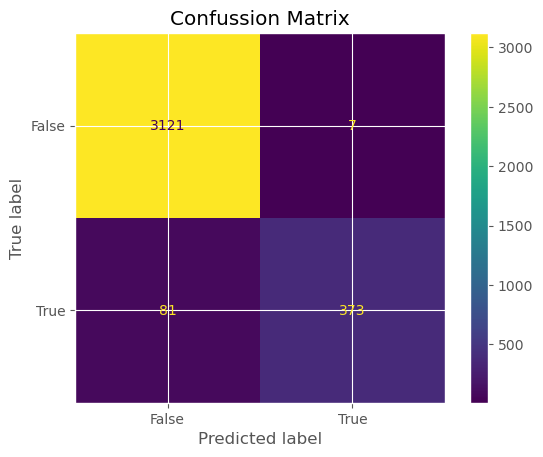

In [14]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss

classifier = LogisticRegressionCV(cv=10, penalty="l1", scoring='neg_log_loss', max_iter=1000, solver="liblinear")
classifier.fit(dist_train, new_train_classes)
pred_probs = classifier.predict_proba(dist_test)
print("Regularization term: ", 1/classifier.C_)

th = sum(new_test_classes)/len(new_test_classes)
print("TH: ", th)

preds = (pred_probs < th)[:, 0]
log_loss = classifier.score(dist_test, new_test_classes)
print("Neg. Log Loss: ", log_loss)

print(f"Matthews corr coef: {matthews_corrcoef(new_test_classes, preds)}, F1: {f1_score(new_test_classes, preds)}, ROC-AUC: {roc_auc_score(new_test_classes, pred_probs[:, 1])}" )


ConfusionMatrixDisplay.from_predictions(new_test_classes, preds)
plt.title("Confussion Matrix")
plt.show()

In [15]:
coefs = classifier.coef_.flatten()
print("Total Nonzero Entries :", sum(coefs != 0))
print("# of Nonzero Entries in class 3 :", sum(coefs[new_train_classes] != 0), " Sum of coefs:", coefs[new_train_classes].sum())
print("# of Nonzero Entries in other classes:", sum(coefs[~new_train_classes] != 0), " Sum of coefs:", coefs[~new_train_classes].sum())

Total Nonzero Entries : 896
# of Nonzero Entries in class 3 : 106  Sum of coefs: -5.0408883281276315
# of Nonzero Entries in other classes: 790  Sum of coefs: 4.80003143339816


Basically the model selects some reference instances from the train data and it gives coefficent in opposite signs considering whether the reference from class 3 or not. This method behaves like a weighted version of KNN and it performs much better than using the plane acceleration information.

## d) 
Provide an overall comparison on the results you obtain for each part (over all tasks). You can
compare test accuracy of each alternative method you developed.

Since task 2 is focused on predictiong gesture 3 I will also create 1NN with manhattan distance just for predicting class 3 to make them comparisable.

Matthews corr coef: 0.9334692091086111, F1: 0.9414414414414415


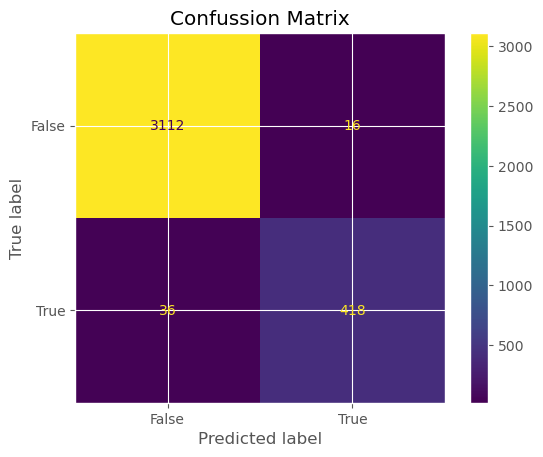

Time Elapsed:  1.717067003250122


In [16]:
K=1
distance = "manhattan"

start = time()
classifier = KNeighborsClassifier(n_neighbors=K, n_jobs=1, metric=distance)
classifier.fit(train_data, new_train_classes)

preds = classifier.predict(test_data)
print(f"Matthews corr coef: {matthews_corrcoef(new_test_classes, preds)}, F1: {f1_score(new_test_classes, preds)}" )

ConfusionMatrixDisplay.from_predictions(new_test_classes, preds)
plt.title("Confussion Matrix")
plt.show()

print("Time Elapsed: ", time()-start)

**Acc Log Reg:** \
Matthews corr coef: 0.574478460648854, F1: 0.628696604600219, ROC-AUC: 0.9090599896346203 \
**Acc Lasso Log Reg:** \
Matthews corr coef: 0.6392718688054163, F1: 0.6172465960665658, ROC-AUC: 0.9781207397726376 \
**Distance Lasso Log. Reg:** \
Matthews corr coef: 0.8838174438283205, F1: 0.8931572629051621, ROC-AUC: 0.997897348941492 \
**1NN:** \
Matthews corr coef: 0.9334692091086111, F1: 0.9414414414414415

In terms of performance, when we consider the threshold selection process 1NN beats the logistic regression models in terms of MCC and F1. Also logistic regression with distance to the train instances performs much better than the methods using the acceration data itself which means the decision boundary between class 3 and others are not likely to be linear in the acceleration data. Also when we check the ROC-AUC score between lasso and non lasso models we see that there is a remarkable imporovement however this is not seen in the F1 score. I think this indicates a problem in threshold determination in the models. With a better tuning Lasso model can reach much more MCC and F1 values. Additionaly, even though the 1NN outperforms Distance Lasso, one might think to use Distance Lasso since it is interpretable. 1NN only says the closest from class 3 or not however the other model says which distances played an effective role in that decision and why the model failed in case of a misclassification.